In [60]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import requests
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTENC
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

The data was obtained from Torontopolice of Ontario, Canada website [link1](https://data.torontopolice.on.ca/datasets/TorontoPS::major-crime-indicators-1/explore?location=43.171926%2C-76.506260%2C7.73)
[link2](https://data.torontopolice.on.ca/datasets/TorontoPS::neighbourhood-crime-rates-2/explore?location=43.678562%2C-79.378187%2C7.73)

In [102]:
crime_rate = pd.read_csv('Neighbourhood_Crime_Rates.csv') # cleaned up data in Excel sheet
crime_indicators = pd.read_csv('Major_Crime_Indicators.csv') #cleaned up in Excel sheet

In [76]:
api_query = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/Major_Crime_Indicators/FeatureServer/0/query?where=1%3D1&outFields=Index_,event_unique_id,Division,occurrencedate,location_type,premises_type,ucr_code,ucr_ext,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude&outSR=4326&f=json"

api_query = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/Major_Crime_Indicators/FeatureServer/0/query?where=1%3D1&outFields=event_unique_id,Division,occurrencedate,location_type,premises_type,ucr_code,ucr_ext,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude&outSR=4326&f=json"
api_query_json = requests.get(api_query).json()
crime_indicators = [hood['attributes'] for hood in api_query_json['features']]
crime_indicators = pd.json_normalize(crime_indicators)
crime_indicators.head(2)

,event_unique_id,Division,occurrencedate,location_type,premises_type,ucr_code,ucr_ext,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude
0,GO-20141273318,D31,1388725200000,"Apartment (Rooming House, Condo)",Apartment,1430,100,Assault,2014.0,January,3.0,3.0,Friday,11,Assault,27,York University Heights,-79.504475,43.766371
1,GO-20141274349,D42,1388725200000,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,200,B&E,2014.0,January,3.0,3.0,Friday,14,Break and Enter,132,Malvern,-79.217083,43.814861


In [101]:
#If using API, might need to do this to use the filterning condition.
"""
mask = crime_indicators['occurrenceyear'].notna()
crime_indicators.loc[mask, 'occurrenceyear'] = crime_indicators.loc[mask, 'occurrenceyear'].astype(int)
"""

We are going to look at crimes only in the year 2021 and we do not want to use occurence year as one of the features

In [106]:
crime_indicators_B = crime_indicators[crime_indicators['occurrenceyear'] == 2021.0]
crime_indicators_B = crime_indicators_B.drop(labels = [ 'X', 'Y', 'Index_', 'ucr_code', 'ucr_ext'], axis = 1)

The same data can be obtained via their API

In [4]:
crime_indicators_B['mci_category'].unique()

array(['Assault', 'Break and Enter', 'Theft Over', 'Robbery',
       'Auto Theft'], dtype=object)

# Exploratory Data Analysis

In [10]:
cat_columns = ['location_type', 'premises_type', 'offence', 'occurrencemonth', 'occurrencedayofweek','mci_category', 'Neighbourhood']

for i in cat_columns:
    #print("Unique values in", i, "are :")
    #print(crime_indicators_B[i].value_counts())
    #print("-" * 100)
    print("##",i,":")
    print(crime_indicators_B[i].value_counts(normalize=True).mul(100).round(2))
    print("*" * 100)

## location_type :
Apartment (Rooming House, Condo)                                          23.92
Single Home, House (Attach Garage, Cottage, Mobile)                       17.95
Streets, Roads, Highways (Bicycle Path, Private Road)                     15.81
Other Commercial / Corporate Places (For Profit, Warehouse, Corp. Bldg    11.54
Parking Lots (Apt., Commercial Or Non-Commercial)                          8.41
Bar / Restaurant                                                           3.99
Open Areas (Lakes, Parks, Rivers)                                          2.08
Schools During Supervised Activity                                         1.52
Convenience Stores                                                         1.28
Ttc Subway Station                                                         1.21
Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)          1.15
Private Property Structure (Pool, Shed, Detached Garage)                   0.91
Hospital / Institutio

In [11]:
# Countplot with counts
def countplotwithcounts(df,var):
    """ This function provides a countplot with counts and percentages for discrete numeric variables."""
    plt.figure(figsize=(20,10))
    #print(df[var].value_counts())
    #print("-"*223)
    print(df[var].value_counts(normalize = True).mul(100).round(1).astype('str') + "%")
    sns.countplot(data = df,x = var,order = df[var].value_counts().index,color='b')

Assault            53.7%
Break and Enter    19.7%
Auto Theft         13.5%
Robbery             9.7%
Theft Over          3.3%
Name: mci_category, dtype: object


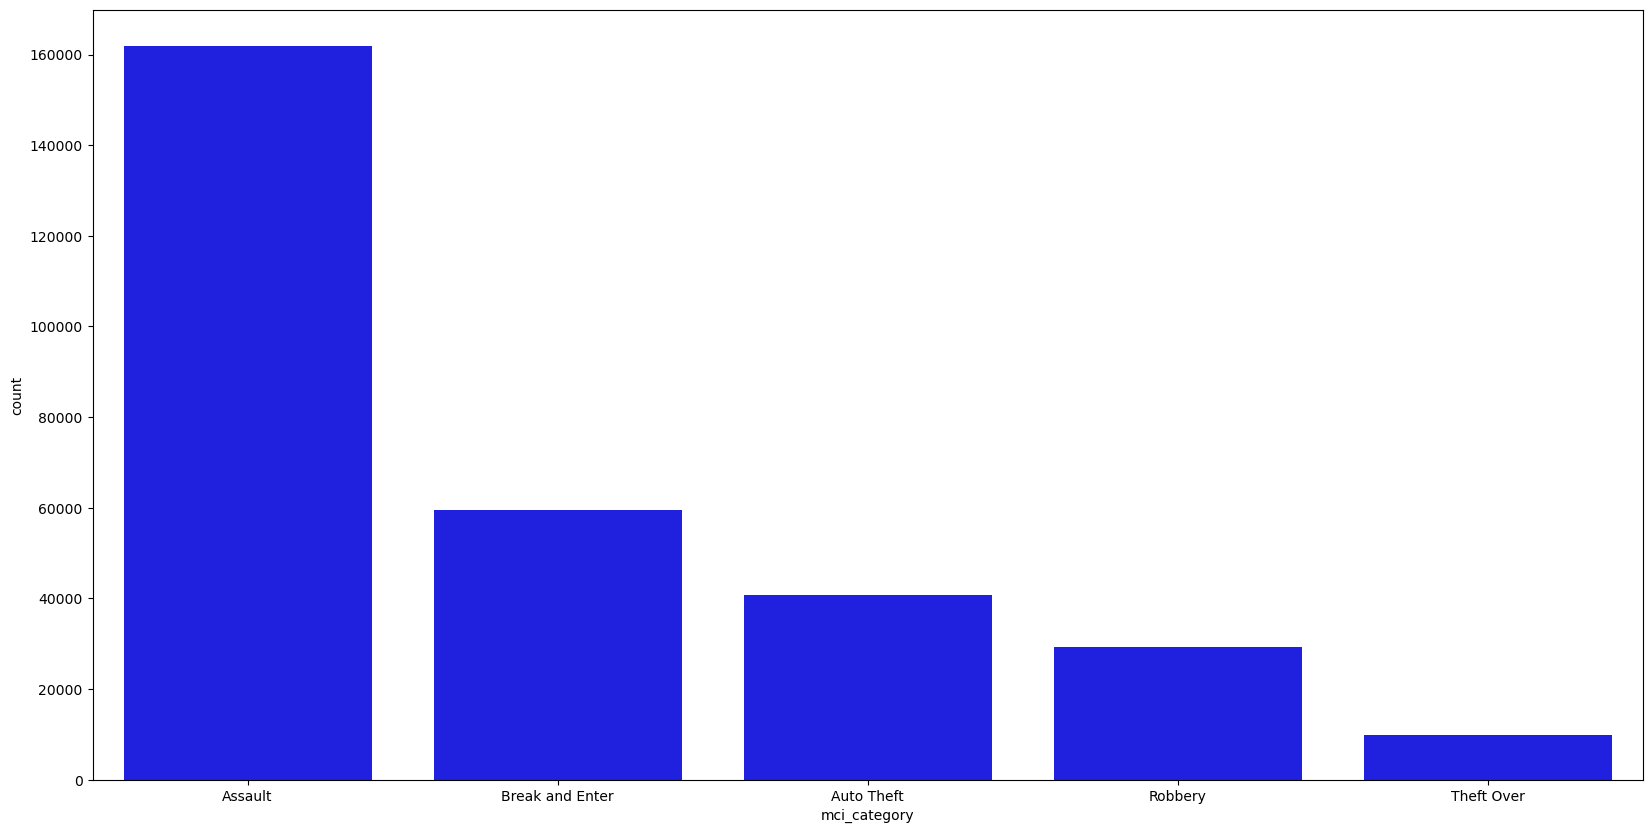

In [12]:
countplotwithcounts(crime_indicators_B,"mci_category")

June         9.1%
May          9.1%
January      8.5%
March        8.5%
October      8.4%
July         8.4%
April        8.3%
August       8.3%
September    8.1%
November     8.0%
December     7.7%
February     7.6%
Name: occurrencemonth, dtype: object


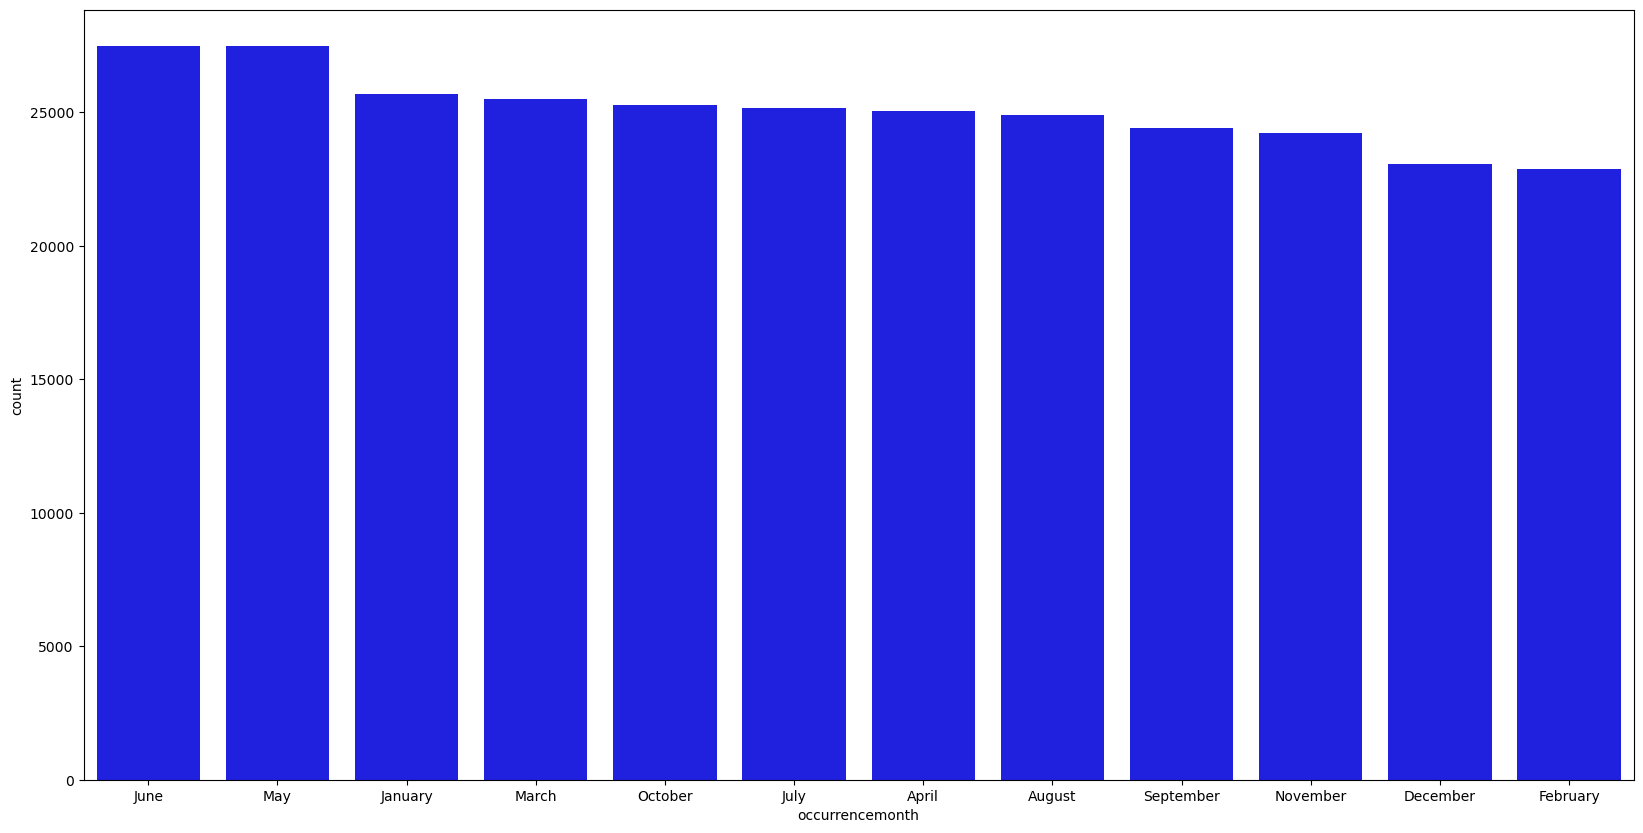

In [13]:
countplotwithcounts(crime_indicators_B,"occurrencemonth")

It is interesting to observe that the highest occurance moth is May and June, maybe assaults happen more in Summer, since everyone goes out in Summer.
<br> 
<br>

0     6.8%
12    5.5%
21    5.4%
18    5.4%
20    5.4%
22    5.3%
19    5.2%
23    5.2%
17    5.1%
15    4.9%
16    4.7%
14    4.2%
1     4.1%
2     4.0%
13    3.9%
11    3.6%
10    3.4%
9     3.3%
3     3.3%
8     2.9%
4     2.5%
7     2.1%
5     2.0%
6     1.8%
Name: occurrencehour, dtype: object


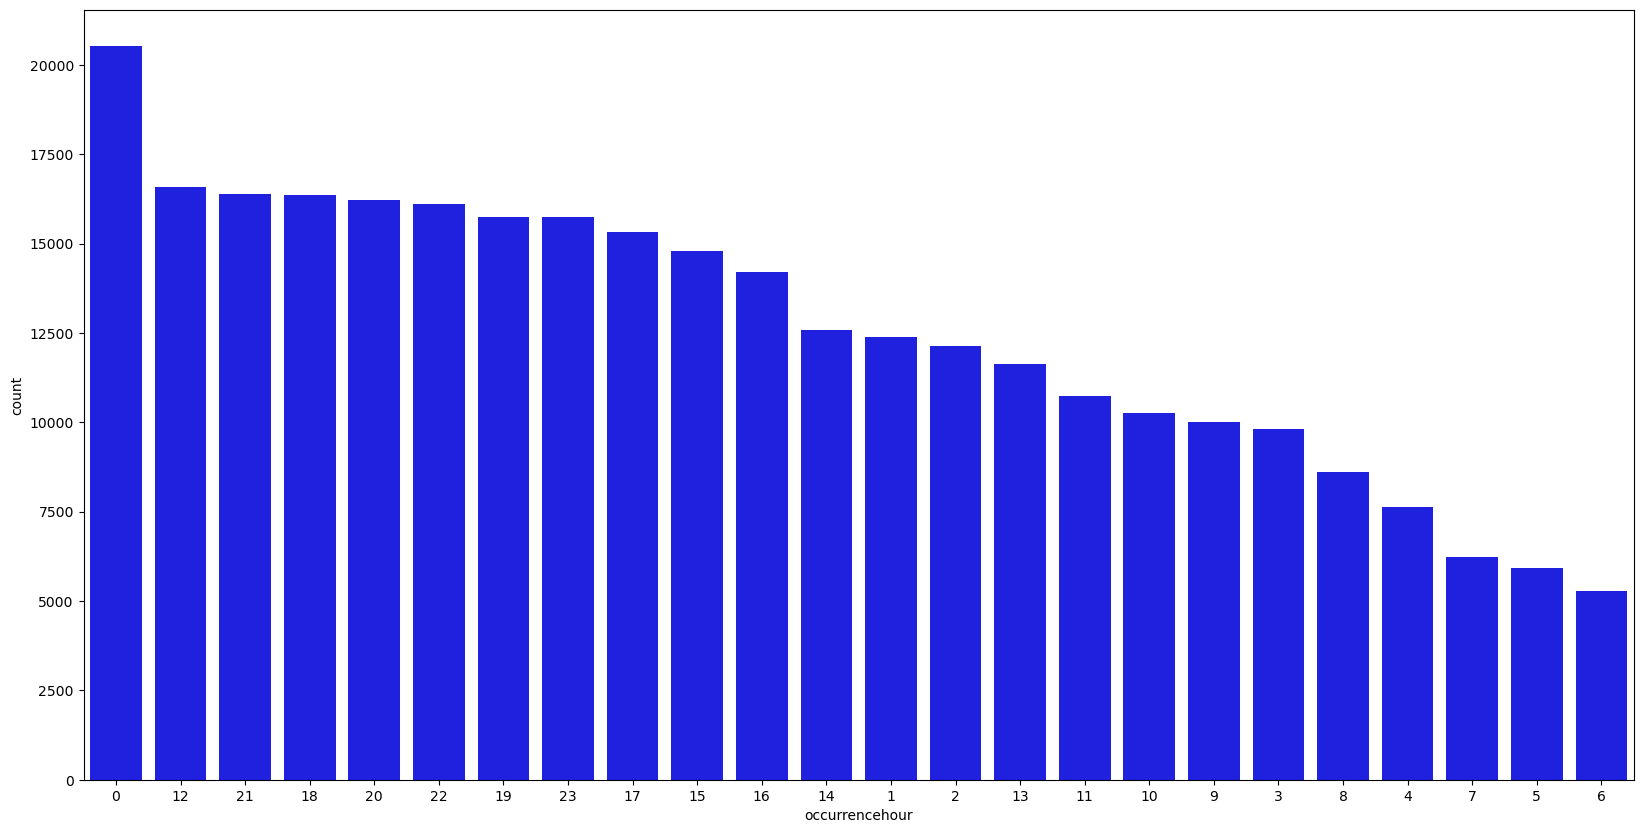

In [14]:
countplotwithcounts(crime_indicators_B, "occurrencehour")

The worst hour is around midnight, next worst timings are around noon, followed by around 9pm.
<br> 
<br>

Friday        15.1%
Saturday      14.8%
Sunday        14.3%
Wednesday     14.1%
Thursday      14.1%
Monday        13.9%
Tuesday       13.7%
Name: occurrencedayofweek, dtype: object


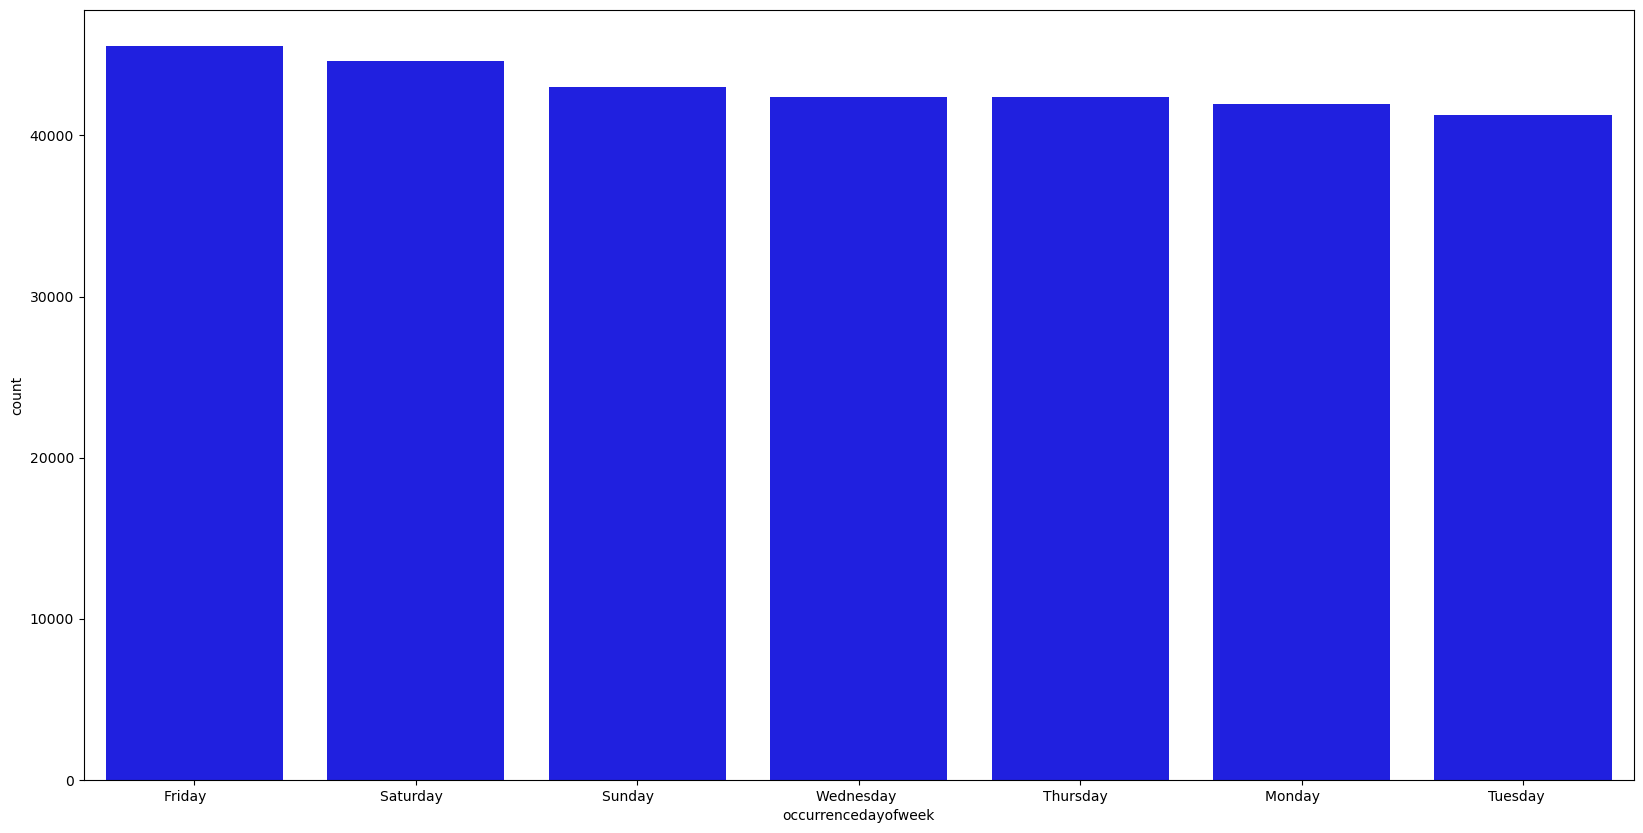

In [15]:
countplotwithcounts(crime_indicators_B, "occurrencedayofweek")

They happen more frequently on Fridays, maybe at the friday parties, huh!
<br> 
<br>

<AxesSubplot:ylabel='Neighbourhood'>

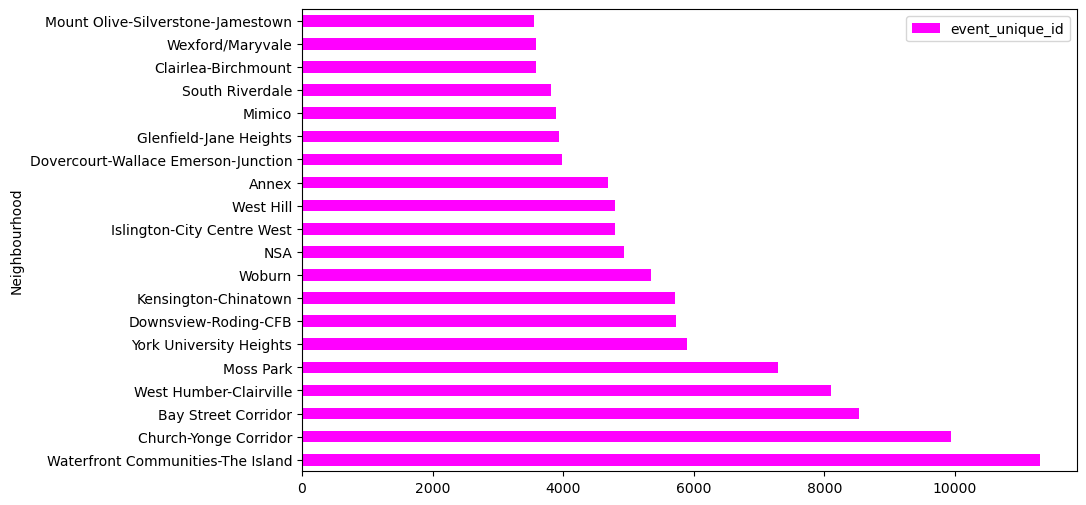

In [16]:
df_hood_grp = crime_indicators_B.groupby('Neighbourhood').count().sort_values(by="event_unique_id", ascending=False).head(20)
df_hood_grp.plot(kind='barh', y='event_unique_id', figsize=(10,6), color='magenta')

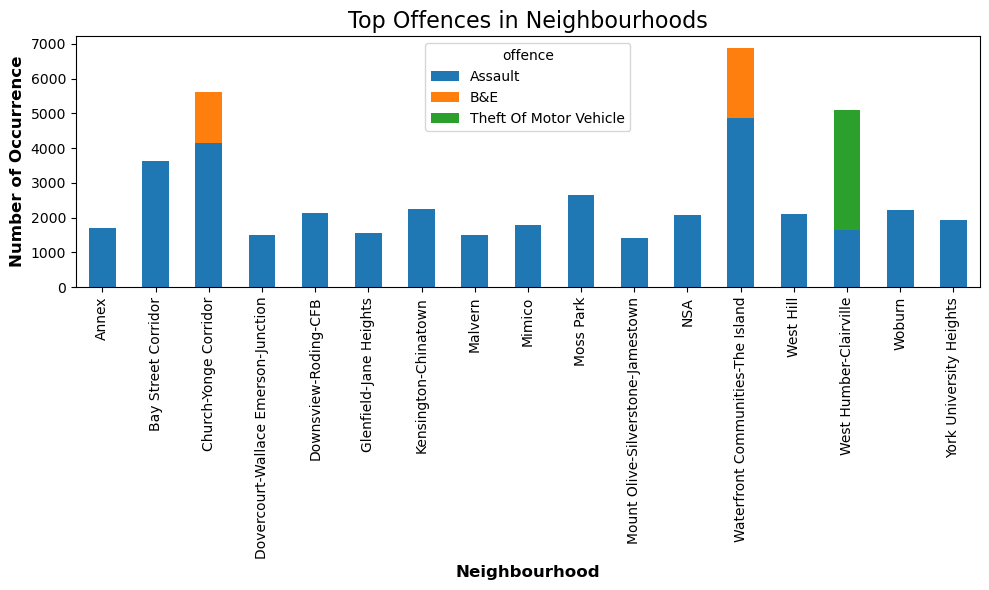

In [17]:
offence_type_by_location = crime_indicators_B.groupby(['Neighbourhood', 'offence']).count().sort_values(by="event_unique_id", ascending=False).head(20)
#offence_type_by_location.plot(kind='barh', y='event_unique_id', figsize=(10,6), color='magenta')
offence_type_by_location = offence_type_by_location.reset_index()
offence_type_by_location.pivot(index='Neighbourhood', columns='offence', values='event_unique_id').plot(kind='bar', stacked=True, figsize=(10,6))
plt.xlabel('Neighbourhood', fontsize=12, fontweight='bold')
plt.ylabel('Number of Occurrence', fontsize=12, fontweight='bold')
plt.title('Top Offences in Neighbourhoods', fontsize=16)
plt.tight_layout()

Text(0, 0.5, 'Number of Occurrence')

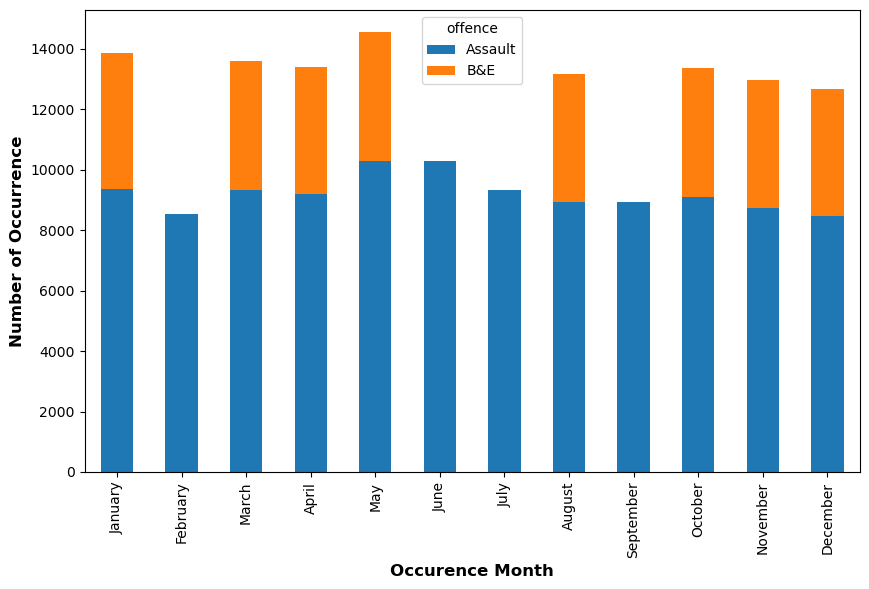

In [18]:
#offence_type_by_location = crime_indicators_B.groupby(['Neighbourhood', 'offence']).count().sort_values(by="event_unique_id", ascending=False).head(20)
crime_indicators_B['occurrencemonth'] = pd.Categorical(crime_indicators_B['occurrencemonth'], 
                                                  categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], 
                                                  ordered=True)
offence_by_month = crime_indicators_B.groupby(['occurrencemonth', 'offence']).count().sort_values(by="event_unique_id", ascending=False).head(20)
offence_by_month = offence_by_month.reset_index()
#sns.heatmap(offence_by_month.pivot(index='occurrencemonth', columns='offence', values='event_unique_id'), cmap='viridis', annot=True)
offence_by_month.pivot(index='occurrencemonth', columns='offence', values='event_unique_id').plot(kind='bar', stacked=True, figsize=(10,6))
plt.xlabel('Occurence Month', fontsize=12, fontweight='bold')
plt.ylabel('Number of Occurrence', fontsize=12, fontweight='bold')

In [124]:
crime_indicators_B.columns

Index(['event_unique_id', 'Division', 'occurrencedate', 'reporteddate',
       'location_type', 'premises_type', 'offence', 'reportedyear',
       'reportedmonth', 'reportedday', 'reporteddayofyear',
       'reporteddayofweek', 'reportedhour', 'occurrenceyear',
       'occurrencemonth', 'occurrenceday', 'occurrencedayofyear',
       'occurrencedayofweek', 'occurrencehour', 'mci_category', 'Hood_ID',
       'Neighbourhood', 'Longitude', 'Latitude'],
      dtype='object')

# Predicting the category of Crime with Gradient boost classifier

In [23]:
X = crime_indicators_B.drop(labels = ['mci_category', 'occurrenceyear', 'reporteddate' , 'offence', 'location_type', 'event_unique_id', 'occurrencedate', 'occurrencedayofyear', 'reportedmonth', 'reportedyear', 'reportedday', 'reporteddayofyear', 'reporteddayofweek','reportedhour'], axis = 1)
#X = crime_indicators_B.drop(labels = ['mci_category' , 'offence', 'location_type', 'event_unique_id', 'occurrencedayofyear', 'occurrencedate'], axis = 1)
y = crime_indicators_B['mci_category']

#print(f"X.shape {X.shape} y.shape {y.shape}")
# Convert the target variable to numerical labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
#print(f"X.shape {X.shape} y.shape {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#cat_cols = ['Division', 'premises_type', 'occurrencemonth', 'occurrencedayofweek', 'Hood_ID', 'Neighbourhood']
#ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)], remainder='passthrough')

#if you want sparse=False, you need to use column transformer, or if you want to make sure that only these categorical columns gets encoded

ohe = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train)

# Initialize an XGBClassifier with default hyperparameters
xgb = XGBClassifier(random_state=42, max_depth=20, n_estimators=100)

xgb.fit(X_train_encoded, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [24]:
X_test_encoded = ohe.transform(X_test)
y_pred = xgb.predict(X_test_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.86      0.77      3766
           1       0.61      0.59      0.60      1320
           2       0.62      0.41      0.50      1132
           3       0.69      0.21      0.33       440
           4       0.20      0.04      0.06       198

    accuracy                           0.67      6856
   macro avg       0.56      0.42      0.45      6856
weighted avg       0.65      0.67      0.64      6856



In [25]:
crime_indicators_B['mci_category'].value_counts()

Assault            18671
Auto Theft          6541
Break and Enter     5717
Robbery             2280
Theft Over          1068
Name: mci_category, dtype: int64

Our data is highly imbalanced, for the first category (class 0) there are 161833 datapoints and for Robbery there are only 29230. Let's see if we try to balance the data by synthetically creating datapoints which look like the particular class and re-build the model, see if the model performs better.

</b>


# Balancing the dataset

I am using SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous) since my labels are categorical.
</b>

I do not want to discard the datapoints with NaN in them, so I use this column transformer where numerical data is processed in a way that take mean values of the neighbouring data to replaces NaN; and in case of categorical data, frequently observed value is taken to replace NaNs (in this way, we do not lose any data)

In [4]:
# X = crime_indicators_B.drop(labels = ['mci_category', 'occurrenceyear', 'reporteddate' , 'offence', 'location_type', 'event_unique_id', 'occurrencedate', 'occurrencedayofyear', 'reportedmonth', 'reportedyear', 'reportedday', 'reporteddayofyear', 'reporteddayofweek','reportedhour'], axis = 1)
# y = crime_indicators_B['mci_category']

Index(['Division', 'premises_type', 'occurrencemonth', 'occurrenceday',
       'occurrencedayofweek', 'occurrencehour', 'Hood_ID', 'Neighbourhood',
       'Longitude', 'Latitude'],
      dtype='object')

In [26]:
numerical_cols = ['occurrenceday', 'occurrencehour', 'Longitude', 'Latitude']
categorical_cols = ['Division', 'premises_type', 'occurrencemonth', 'occurrencedayofweek', 'Hood_ID', 'Neighbourhood']

preprocessor = ColumnTransformer(
               [('num', SimpleImputer(strategy='mean'), numerical_cols),
                ('imputer', SimpleImputer(strategy='most_frequent'), categorical_cols)
               ])

X_prep = preprocessor.fit_transform(X) # mainly to deal with NaNs

#because I can't give X_prep directly to smotenc, since its an array and I need column index to be the same, noting that the column order is different here
X_prep_df = pd.DataFrame(X_prep, columns =  ['occurrenceday', 'occurrencehour', 'Longitude', 'Latitude', 'Division', 'premises_type', 'occurrencemonth', 'occurrencedayofweek', 'Hood_ID', 'Neighbourhood'])

print(X_prep_df.shape)
print(y.shape)

smotenc = SMOTENC(categorical_features = [4,5, 6, 7, 8, 9])
X_resampled, y_resampled = smotenc.fit_resample(X_prep_df, y)

(34277, 10)
(34277,)


In [27]:
y_resampled = label_encoder.fit_transform(y_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

cat_cols = ['Division', 'premises_type', 'occurrencemonth', 'occurrencedayofweek', 'Hood_ID', 'Neighbourhood']

ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)], remainder='passthrough')
X_train_encoded = ct.fit_transform(X_train)

xgb_resam = XGBClassifier(random_state=42, max_depth=20, n_estimators=100)

xgb_resam.fit(X_train_encoded, y_train)

C:\Users\Varun\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [28]:
X_test_encoded = ct.transform(X_test)
y_pred = xgb_resam.predict(X_test_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      3701
           1       0.87      0.87      0.87      3842
           2       0.86      0.85      0.85      3768
           3       0.93      0.92      0.92      3788
           4       0.94      0.94      0.94      3572

    accuracy                           0.87     18671
   macro avg       0.87      0.87      0.87     18671
weighted avg       0.87      0.87      0.87     18671



# Ordinal encoding

In [30]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [31]:
X_train_encoded = enc.fit_transform(X_train)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# xgb_resam_ordinal = XGBClassifier()

# parameters = {
#     'max_depth': range (20, 70, 100),
#     'n_estimators': range(50, 220, 340)
# }

# grid_search = GridSearchCV(
#     estimator=xgb_resam_ordinal,
#     param_grid=parameters,
#     n_jobs = 10,
#     cv = 10,
#     verbose=True
# )

# grid_search.fit(X_train_encoded, y_train)

# grid_search.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [32]:
X_test_encoded = enc.transform(X_test)

#xgb_resam_ordinal = XGBClassifier(max_depth=50, n_estimators=100)
#xgb_resam_ordinal = XGBClassifier(max_depth=60, n_estimators=100)
#xgb_resam_ordinal = XGBClassifier()

xgb_resam_ordinal = XGBClassifier(max_depth=70, n_estimators=300)

xgb_resam_ordinal.fit(X_train_encoded, y_train)
y_pred = xgb_resam_ordinal.predict(X_test_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.76      0.42      3701
           1       0.59      0.40      0.47      3842
           2       0.59      0.30      0.40      3768
           3       0.67      0.30      0.41      3788
           4       0.44      0.32      0.37      3572

    accuracy                           0.42     18671
   macro avg       0.51      0.42      0.41     18671
weighted avg       0.52      0.42      0.42     18671



In [33]:
X_resampled.head(2)

,occurrenceday,occurrencehour,Longitude,Latitude,Division,premises_type,occurrencemonth,occurrencedayofweek,Hood_ID,Neighbourhood
0,4.0,4.0,-79.446422,43.666726,D11,Commercial,January,Monday,93,Dovercourt-Wallace Emerson-Junction
1,2.0,19.0,-79.434385,43.632949,D14,Outside,January,Saturday,85,South Parkdale


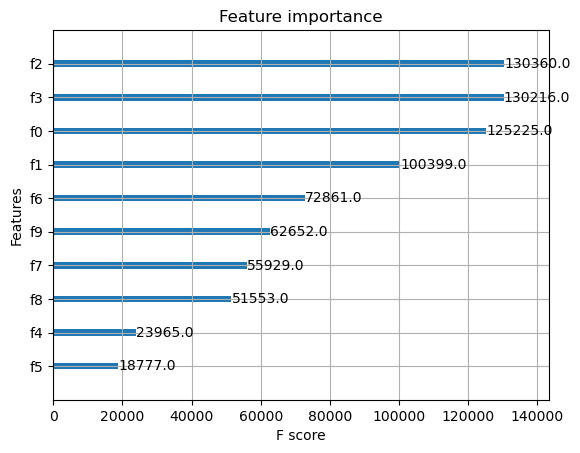

In [34]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_resam_ordinal)
plt.show()

# Re building the model with only important features

Let's rebuilt our model with as few features as possible, for this we are going to use feature importance score from our *ordinal encoding* model. The model with Ordinal encoding does not perform very well even with balanced dataset. But it still has accuracy around 60%.

Longitute and lattitute gives us location coordiantes and instead we are going to use Hood_ID. 
We are going to remove Division and occurrenceday from our features since they do not seem to impact. 

In [69]:
#X = crime_indicators_B.drop(labels = ['Longitude', 'Latitude', 'Division', 'Hood_ID', 'occurrencemonth', 'mci_category', 'occurrenceyear', 'reporteddate' , 'offence', 'location_type', 'event_unique_id', 'occurrencedate', 'occurrencedayofyear', 'occurrencedayofweek', 'reportedmonth', 'reportedyear', 'reportedday', 'reporteddayofyear', 'reporteddayofweek','reportedhour'], axis = 1)
X = crime_indicators_B[['premises_type', 'occurrenceday', 'occurrencehour','Neighbourhood']]
y = crime_indicators_B['mci_category']

numerical_cols = ['occurrenceday', 'occurrencehour']
categorical_cols = [ 'premises_type', 'Neighbourhood']

preprocessor = ColumnTransformer(
               [('num', SimpleImputer(strategy='mean'), numerical_cols),
                ('imputer', SimpleImputer(strategy='most_frequent'), categorical_cols)
               ])

X_prep = preprocessor.fit_transform(X)

In [75]:
X_prep_df = pd.DataFrame(X_prep, columns =  ['occurrenceday', 'occurrencehour', 'premises_type', 'Neighbourhood'])

smotenc = SMOTENC(categorical_features = [2,3])
X_resampled, y_resampled = smotenc.fit_resample(X_prep_df, y)

y_resampled = label_encoder.fit_transform(y_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=41)

ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols)], remainder='passthrough')
X_train_encoded = ct.fit_transform(X_train)

xgb_resam = XGBClassifier(random_state=10, max_depth=30, n_estimators=120)
xgb_resam.fit(X_train_encoded, y_train)

X_test_encoded = ct.transform(X_test)
y_pred = xgb_resam.predict(X_test_encoded)

print(classification_report(y_test, y_pred))

C:\Users\Varun\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.73      0.72      0.73      3774
           1       0.81      0.83      0.82      3701
           2       0.82      0.81      0.82      3751
           3       0.90      0.89      0.90      3773
           4       0.90      0.89      0.90      3672

    accuracy                           0.83     18671
   macro avg       0.83      0.83      0.83     18671
weighted avg       0.83      0.83      0.83     18671



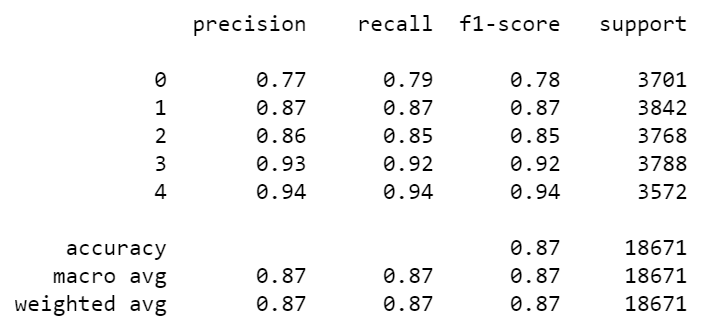

Comparing this with our previous model where we Balance the dataset using SMOTENC, where we use the same dataset except the number of features, we can see that we obtain a very similar performance of the model with lesser featues (I am also showing numbers from the previous model for easier comparison)